This project explores Metric Learning methods in relation to the task of Traffic Signs Recognition. It contains data augmentation realization, specifically it is custom synthetic images generation, implementation of different DL models with it's evaluation

It uses [GTSRB](https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/) dataset which contains around 50.000 images of signs in total.

Images of some part of road signs classes were removed from the data so that using Metric Learning is reasonable.  

In [8]:
import numpy as np
import pandas as pd
import torch
import os
from os.path import join

- Models and their training logic stored in a folder named ```code/models.py```
- Custom Datasets, Samplers and Dataloader's logic stored in a folder ```code/data_management.py```
- Synthetic samples generation logic stored in a folder ```code/sign_generator.py``` 
- (part of) Modified GTSRB dataset is located in ```data/```
- weights of pretrained models stored in a folder ```models/``` 

In [2]:
dataset_path = "data/"
train_path = "data/Train"
test_path = "data/Test"
meta_path = "data/Meta"
syntdata_path = "data/synt_data"
output_path = "models/"
classes_json_path = "data/classes.json"
annotations_test = join(dataset_path, "Test.csv")
annotations_train = join(dataset_path, "Train.csv")
CLASSES_CNT = 43

Let's have a look at our data for our recognition task

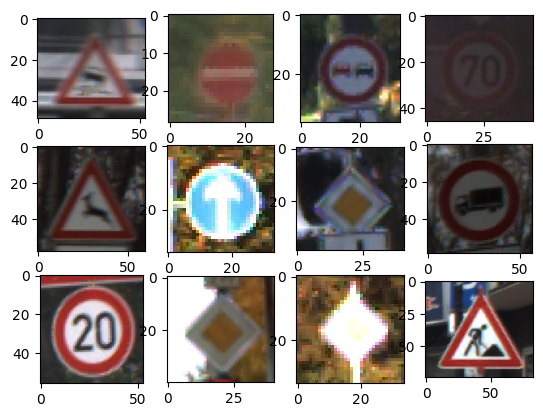

In [3]:
import matplotlib.pyplot as plt
from torchvision.io import read_image

objects = os.listdir(test_path)
objects = [objects[x] for x in np.random.randint(low=0, high=len(objects), size=12)]

for i, obj in enumerate(objects):
    img = read_image(join(test_path, obj)).permute(1, 2, 0).numpy()
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    

One can notice that images of traffic signs sometimes are pretty distorted due to the fact that they are viewed inside a moving car. 

They might be:
- darkened
- blurred
- illuminated
- low-quality
- transformed in different dimension

Moreover, one of the main problem in road sign recognition task is the large classes disbalance. In our dataset we have 43 classes in total; 12 among them are **rare**. Rare classes in dataset have very limited amount of samples presented in the training dataset. But we'd like to recognize them with a relativelt high precision anyway. 

Let's train simple classificator as a **baseline** and measure it's performance

In [4]:
from code.models import train_simple_classifier, test_classifier

In [5]:
# Train
train_simple_classifier(
    train_pathes=[train_path],
    output_path=join(output_path, "simple_classifier.pth"),
    classes_json=classes_json_path,
    epochs=1
)

/home/eug/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 11.7 M
---------------------------------
11.1 M    Trainable params
683 K     Non-trainable params
11.7 M    Total params
46.984    Total estimated model params size (MB)
/home/eug/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider

Epoch 0:   0%|                                                                                                           | 0/119 [00:00<?, ?it/s]

/home/eug/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 256. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 0:   5%|████▏                                                                              | 6/119 [00:21<06:39,  0.28it/s, acc_step=0.414]

/home/eug/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


SimpleClassifier(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [9]:
# Test
from code.models import SimpleClassifier

model_path = join(output_path, "simple_classifier.pth")

model = SimpleClassifier()
model.load_state_dict(torch.load(model_path))
model.eval()

ans = test_classifier(model,
                      test_path,
                      classes_json_path,
                      annotations_test)

print(f"total_acc: {ans[0]}\nrare_acc: {ans[1]}\nfreq_acc: {ans[2]}")

total_acc: 0.7497228820269201
rare_acc: 0.0
freq_acc: 0.9652395514780836


As we can see, accuracy on rare classes is near zero, whereas accuracy on frequent classes is quite fine.

## Generating synthetic data

There is a pregrenerated collection of images samples. It was obtained by applying the following procedure:

- an icon of road sign was choosen
- transformations such as
      random coloring, random rotation, convolution with a shift and Gaussian kernels
  were applied
- icon was embedded on a random background choosen from ```data/backgrounds``` folder

Let's see how synthetic generated images actually look like

In [28]:
from code.sign_generator import generate_synt_sample

generate_synt_sample(
    ["data/Meta/2.png",
    "",
    "data/backgrounds",
    6]
)

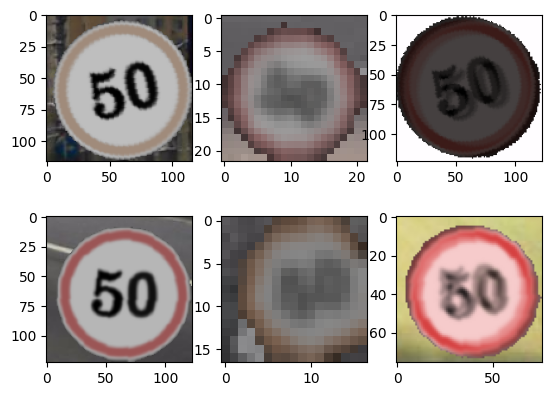

In [29]:
for i, path in enumerate(os.listdir("2")):
    plt.subplot(2, 3, i + 1)
    img = read_image(join("2", path)).permute(1, 2, 0).numpy()
    plt.imshow(img)
    

## Train simple classifier on a mixture of syntetic generated data and source train data

In [11]:
# Train
from code.models import train_synt_classifier

train_synt_classifier(
    train_path,
    syntdata_path,
    join(output_path, "simple_classifier_synt.pth"),
    classes_json_path,
    epoch=2
)

/home/eug/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 11.7 M
---------------------------------
11.1 M    Trainable params
683 K     Non-trainable params
11.7 M    Total params
46.984    Total estimated model params size (MB)
/home/eug/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider

Epoch 0: 100%|████████████████████████████████████████████████████████████████████████████████▋| 286/287 [18:33<00:03,  0.26it/s, acc_step=0.984]

/home/eug/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 137. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 1: 100%|████████████████████████████████████████████████████████████████| 287/287 [18:20<00:00,  0.26it/s, acc_step=0.993, acc_epoch=0.987]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|████████████████████████████████████████████████████████████████| 287/287 [18:20<00:00,  0.26it/s, acc_step=0.993, acc_epoch=0.987]


SimpleClassifier(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [13]:
# Test
model_path = join(output_path, "simple_classifier_synt.pth")

model = SimpleClassifier()
model.load_state_dict(torch.load(model_path))
model.eval()

ans = test_classifier(model,
                      test_path,
                      classes_json_path,
                      annotations_test)

print(f"total_acc: {ans[0]}\nrare_acc: {ans[1]}\nfreq_acc: {ans[2]}")

total_acc: 0.9010292953285828
rare_acc: 0.6528368794326241
freq_acc: 0.972375127420999


Though the quality of the model trained on the mixture of synthetic and source data is rather good for rare classes, it's possible to make this model perform better: 

We will use weighted sum of Contrastive Loss and CE loss while train our next model.

## Train model with contrastive loss

In [14]:
# Train
from code.models import train_embedding_network, EmbeddingNetwork

train_embedding_network(
    train_path,
    syntdata_path,
    join(output_path, "embedding_model.pth"),
    classes_json_path,
    epochs=7
)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training: |          | 0/? [00:00<?, ?it/s]

EmbeddingNetwork(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [15]:
# Test
model_path = join(output_path, "embedding_model.pth")

model = EmbeddingNetwork()
model.load_state_dict(torch.load(model_path))
model.eval()

ans = test_classifier(model,
                      test_path,
                      classes_json_path,
                      annotations_test)

print(f"total_acc: {ans[0]}\nrare_acc: {ans[1]}\nfreq_acc: {ans[2]}")

total_acc: 0.918923198733175
rare_acc: 0.6932624113475178
freq_acc: 0.9837920489296637


Now it's time to add KNN upon our trained Embedding Network

## Train model with KNN head and measure it's performance

In [22]:
from code.models import train_model_with_knn, KnnModel

train_model_with_knn(
    join(output_path, "embedding_model.pth"),
    syntdata_path,
    join(output_path, "knn_model.bin"),
    classes_json_path,
    examples_per_class=50
)

In [23]:
nn_path = join(output_path, "embedding_model.pth")
knn_head_path = join(output_path, "knn_model.bin")

model = KnnModel(n_neighbors=1)
model.load_nn(nn_path)
model.load_head(knn_head_path)
model.eval()

ans = test_classifier(model,
                      test_path,
                      classes_json_path,
                      annotations_test)

print(f"total_acc: {ans[0]}\nrare_acc: {ans[1]}\nfreq_acc: {ans[2]}")

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


total_acc: 0.9197941409342835
rare_acc: 0.7042553191489361
freq_acc: 0.9817533129459735


As we can see, it helped us to achieve better quality on rare classes and along with it 